In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

IF isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function. <br>
Random partitioning produces noticeably shorter paths for anomalies.

## Loading Dataset

In [56]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")

# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0], Dataset_std.shape[0]/5, random_state=22)
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])

# Checking distribution before and after shortening
print("Original Dataset Shape: ", Dataset_std.shape)
print("Reduced Dataset Shape: ", Dataset_std_short.shape)

Original Dataset Shape:  (157800, 36)
Reduced Dataset Shape:  (31560, 36)


oversampling

In [57]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_norm_short, Attack_label_short)
print("Target Shape: ", Attack_label_short.shape)
print("Resampled Target Shape: ", Target_res.shape)

print(Attack_label_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Target Shape:  (31560, 1)
Resampled Target Shape:  (42446, 1)
Attack_label
1               0.8468
0               0.1532
Name: proportion, dtype: float64
Attack_label
0               0.505065
1               0.494935
Name: proportion, dtype: float64


In [58]:
# seperating Datasamples with normal and abnormal samples
Dataset_only0 = Dataset_res.loc[Target_res['Attack_label'] == 0] # normal label
Dataset_only1 = Dataset_res.loc[Target_res['Attack_label'] == 1] 
print("Sample shape of only normal label", Dataset_only0.shape)
print("Sample shape of only abnormal label", Dataset_only1.shape)

Sample shape of only normal label (21438, 36)
Sample shape of only abnormal label (21008, 36)


In [59]:
from sklearn.model_selection import train_test_split
array_train_0, array_test_0 = train_test_split(Dataset_only0, train_size=0.5, random_state=22)
array_train_1, array_test_1 = train_test_split(Dataset_only1, train_size=0.05, random_state=22)
print("array_train_0 shape: ", array_train_0.shape, "\narray_train_1 shape: ", array_train_1.shape)

X_train_val = pd.concat([array_train_0, array_train_1])
Y_train_val = pd.concat([pd.DataFrame([1]*array_train_0.shape[0]), pd.DataFrame([-1]*array_train_1.shape[0])])
X_test = pd.concat([array_test_0, array_test_1])
Y_test = pd.concat([pd.DataFrame([1]*array_test_0.shape[0]), pd.DataFrame([-1]*array_test_1.shape[0])]) 

array_train_0 shape:  (10719, 36) 
array_train_1 shape:  (1050, 36)


In [60]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.5, random_state=22)
print("Shape of X_val: ", X_val.shape)

Shape of X_val:  (5885, 36)


## Hyperparameter

In [61]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

parameters = {
    'n_estimators': [25, 50, 100, 150],
    'max_samples': ['auto', 0.5, 0.75],
    'max_features': [1.0, 0.5, 0.75],
    'bootstrap': [True, False]
}

IF = IsolationForest(random_state=42, contamination= (Y_val.iloc[:,0] == -1).sum() / len(Y_val))

# Scoring function
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = f1_score(y, y_pred, pos_label=-1)
    roc = roc_auc_score(y, y_pred)
    # Composite score
    score = f1 + roc - (fp + fn)
    return score

# Set up the GridSearchCV
grid_search = GridSearchCV(IF, parameters, scoring= custom_scorer, cv=3, refit= True)

# fitting grid search
grid_search.fit(X_val, Y_val)

print('Best parameters: ',  grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'bootstrap': False, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 25}
Best score:  -186.49625362773295


## The modal

In [62]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=22, contamination=(Y_train.iloc[:,0] == -1).sum() / len(Y_train),
                      max_samples=0.5,  max_features= 0.5,
                      n_estimators=25, bootstrap=False)
clf.fit(X_train)
Y_pred = clf.predict(X_test)

### Evaluation

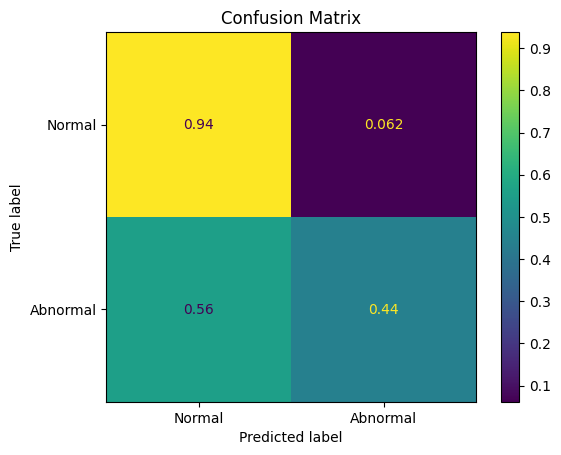

Average Accuracy Score: 0.6159663591615868
Balanced Accuracy Score: 0.6905170907417565
         Precision   Recall  F1-Score
Anomaly   0.930142  0.44298  0.600143


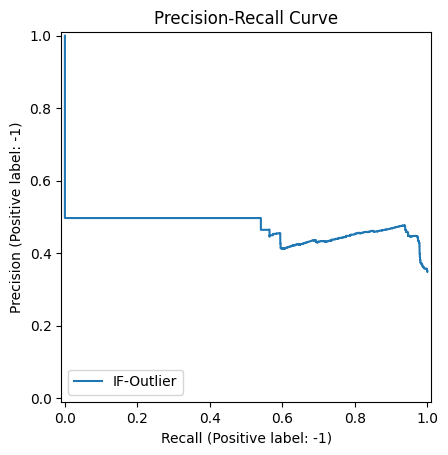

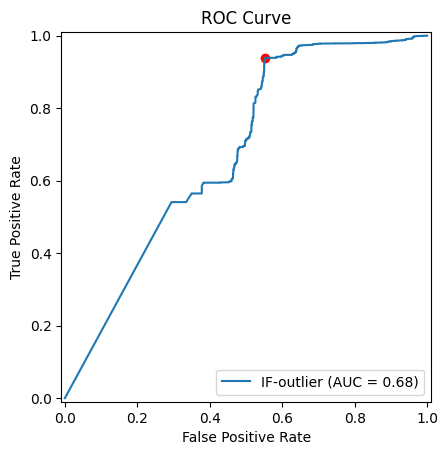

In [63]:
import numpy as np
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix')   
plt.show()

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,labels=[-1], average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# FOR Prec-Recall and ROC, decision function scores are needed (not just -1 or 1 labels)
Y_scores = clf.decision_function(X_test)

#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_scores)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, pos_label= -1, estimator_name='IF-Outlier').plot()
plt.title('Precision-Recall Curve')

# ROC Curve
fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_scores)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='IF-outlier')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()

## The Modal after PCA

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_PCA = pca.fit_transform(X_train)
X_PCA_test = pca.transform(X_test)

clf = IsolationForest(random_state=22, contamination=(Y_train.iloc[:,0] == -1).sum() / len(Y_train),
                      max_samples=0.5,  max_features= 0.5,
                      n_estimators=25, bootstrap=False)
clf.fit(X_PCA)
Y_pred = clf.predict(X_PCA_test)

### Evaluation

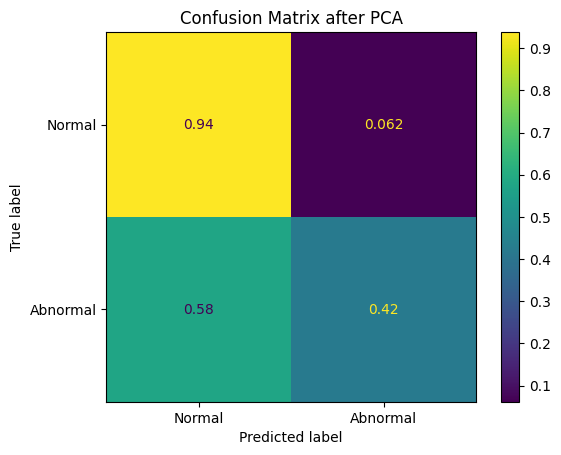

Average Accuracy Score: 0.6040355967011116
Balanced Accuracy Score: 0.6813910223691041
         Precision    Recall  F1-Score
Anomaly   0.927531  0.424542  0.582477


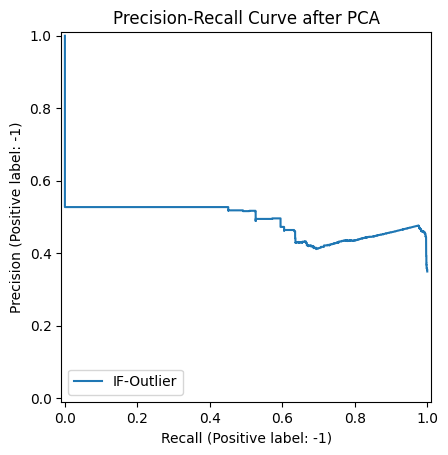

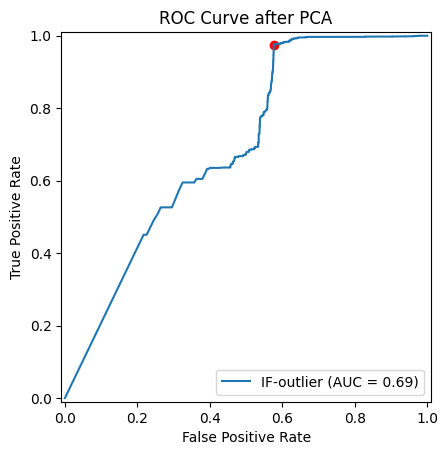

In [65]:
import numpy as np
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, Y_pred, normalize= 'true', labels=[1, -1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot()
plt.title('Confusion Matrix after PCA')   
plt.show()

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,labels=[-1], average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, labels=[-1], average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# FOR Prec-Recall and ROC, decision function scores are needed (not just -1 or 1 labels)
Y_scores = clf.decision_function(X_PCA_test)

#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_scores)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, pos_label= -1, estimator_name='IF-Outlier').plot()
plt.title('Precision-Recall Curve after PCA')

# ROC Curve
fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_scores)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='IF-outlier')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve after PCA")
plt.show()

## Conclusion

The Isoltion Forest have a result of high precision but low recall for binary classification, that means the modal is good in identifying a abnormal sample but it doesnt identify all the abnormal sample. In conclusion the modal produce a moderate result. 